# Onset Detection & Analysis

In [1]:
import numpy as np
import librosa
from matplotlib import pyplot as plt
from scipy import signal

## Calculate Novelty & Detect Onset

In [2]:
def calculate_novelty(x, win_size, n_f, hop_size=False):
    
    """ Calulate a novelty curve
    
    Parameters
    ----------
    
    x: np.array
        input audio
    
    win_size: int
        Size of the analysis window
    
    n_f: string
        Either "spectral" or "energy"
    
    hop_size: int
        Hop size used for spectral flux
        
    Returns
    -------
    
    novelty: np.array
        novelty curve
        
    """
    
    length = len(x)
    pad_length = win_size - length % win_size
    x = np.pad(x, (0, pad_length), 'constant') # Zero pad signal if window doesn't align
    w = signal.hann(win_size)
    n_frame = len(x) // win_size
    
    if n_f == 'energy':
        local_energy = np.zeros_like(x)

        for i in range(n_frame):
            local_energy[i * win_size : i * win_size + win_size] = abs(x[i * win_size : i * win_size + win_size]  * w) ** 2

        local_energy_diff = np.diff(local_energy)
        novelty_function = local_energy_diff
        novelty_function[local_energy_diff < 0 ] = 0

    elif n_f == 'spectral':
        hop_len = win_size // 4
        
        stft = librosa.stft(x, n_fft=win_size, hop_length=hop_len, win_length=None, window='hann', center=False, dtype=None)
        stft_log = np.log10(1 + 50 * abs(stft))
        
        freq_bin = int(1 + win_size/2)
        stft_len = len(stft_log[0,:])
        spec_flux = np.zeros_like(x)
        
        i = 0
        while i < stft_len - 1:
            for k in range(freq_bin):
                spec_flux[i * hop_len : i * hop_len + win_size] += (stft_log[k, i+1] - stft_log[k, i])
            i += 1
        
        novelty_function = spec_flux
        novelty_function[spec_flux < 0] = 0
    
    return novelty_function

In [3]:
x, fs = librosa.load("audio/drums.aif")

calculate_novelty(x, win_size=1024, n_f='energy', hop_size=False)

array([2.2044605e-17, 0.0000000e+00, 1.0696613e-15, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

In [4]:
def detect_onsets(n_fn, mean_len, max_len, delta):
    
    """ Detect onsets from a novelty curve
    
    Parameters
    ----------
    
    n_fn: np.array
        input novelty curve
    
    mean_len: int
        before and after each sample, used to calculate threshold
    
    max_len: int
        window around n used to determine if n is a peak
        
    delta: int
         amount to vertically adjust the threshold (start with delta = 0.05)
      
    
    Returns
    -------
    
    onsets: np.array
        detected onsets (frame number)

    """
    mean_len_half = mean_len // 2
    max_len_half = max_len // 2
    wait = 2205
    
    return librosa.util.peak_pick(x=n_fn, pre_max=max_len_half, post_max=max_len_half, pre_avg=mean_len_half, post_avg=mean_len_half, delta=delta, wait=wait)

In [5]:
def evaluate_onsets(reference_onsets, detected_onsets, tolerance):
    
    """ Calculate the precision, recall, and F-measure of the onsets.
    
    Parameters
    ----------
    
    reference_onsets: np.array
        reference onsets
    
    detected_onsets: np.array
        detected onsets
    
    tolerance: int
        tolerance window (samples)
    
    
    Returns
    -------
    
    eval: np.array
        Three-element np.array with Precision, Recall, and F-Measure
    
    """
    tolerance_half = tolerance // 2 # Before and after detected onset
    reference_onsets *= fs # Convert seconds in csv file to sample
    reference_onsets = reference_onsets.astype(int)
    ref_len = len(reference_onsets)
    detected_len = len(detected_onsets)
    
    true_positives = 0
    false_negatives = 0
#     print(detected_onsets)
#     print(reference_onsets)
    
    for i  in range(ref_len):
        in_tolerance_win = False # Check if there's already and detected onset in tolerance window
        
        ref_beat = reference_onsets[i]
        tolerance_win = np.arange(ref_beat - tolerance_half, ref_beat + tolerance_half + 1) # Samples
        
        while not in_tolerance_win:
            for k in range(detected_len):
                if detected_onsets[k] in tolerance_win:
                    true_positives += 1
                    in_tolerance_win = True # Count only one when more than one is in the tolerance window
                else:
                    continue
            false_negatives += 1 # add one if it's not in the tolerance window
            break
    
    false_positives = detected_len - true_positives
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    f_measure = 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0
    
    return np.array([precision, recall, f_measure])

In [6]:
x, fs = librosa.load("audio/drums.aif")
reference_onsets = np.genfromtxt('audio/drums_reference.csv', delimiter=',')

tolerance = int(fs * 0.03)

# # Energy Based Novelty
# n_fn = calculate_novelty(x, win_size=1024, n_f='energy', hop_size=False)
# detected_onsets = detect_onsets(n_fn, mean_len=14, max_len=14, delta=0.05)
# evaluated_onsets = evaluate_onsets(reference_onsets, detected_onsets, tolerance)

# Spectral Flux
n_fn = calculate_novelty(x, win_size=128, n_f='spectral', hop_size=False)
detected_onsets = detect_onsets(n_fn, mean_len=14, max_len=14, delta=0.05)
evaluated_onsets = evaluate_onsets(reference_onsets, detected_onsets, tolerance)
print(evaluated_onsets)

[0.1        0.2        0.13333333]


## Onset Analysis
Analyze onset deteciton methods (Energy and Spectral Flux) and parameters that generate the most accurate results.

Energy f-measure: 0.5555555555555556
Spectral Flux f-measure: 0.11764705882352941


([<matplotlib.axis.XTick at 0x1ffbd7d3608>,
 <a list of 5 Text xticklabel objects>)

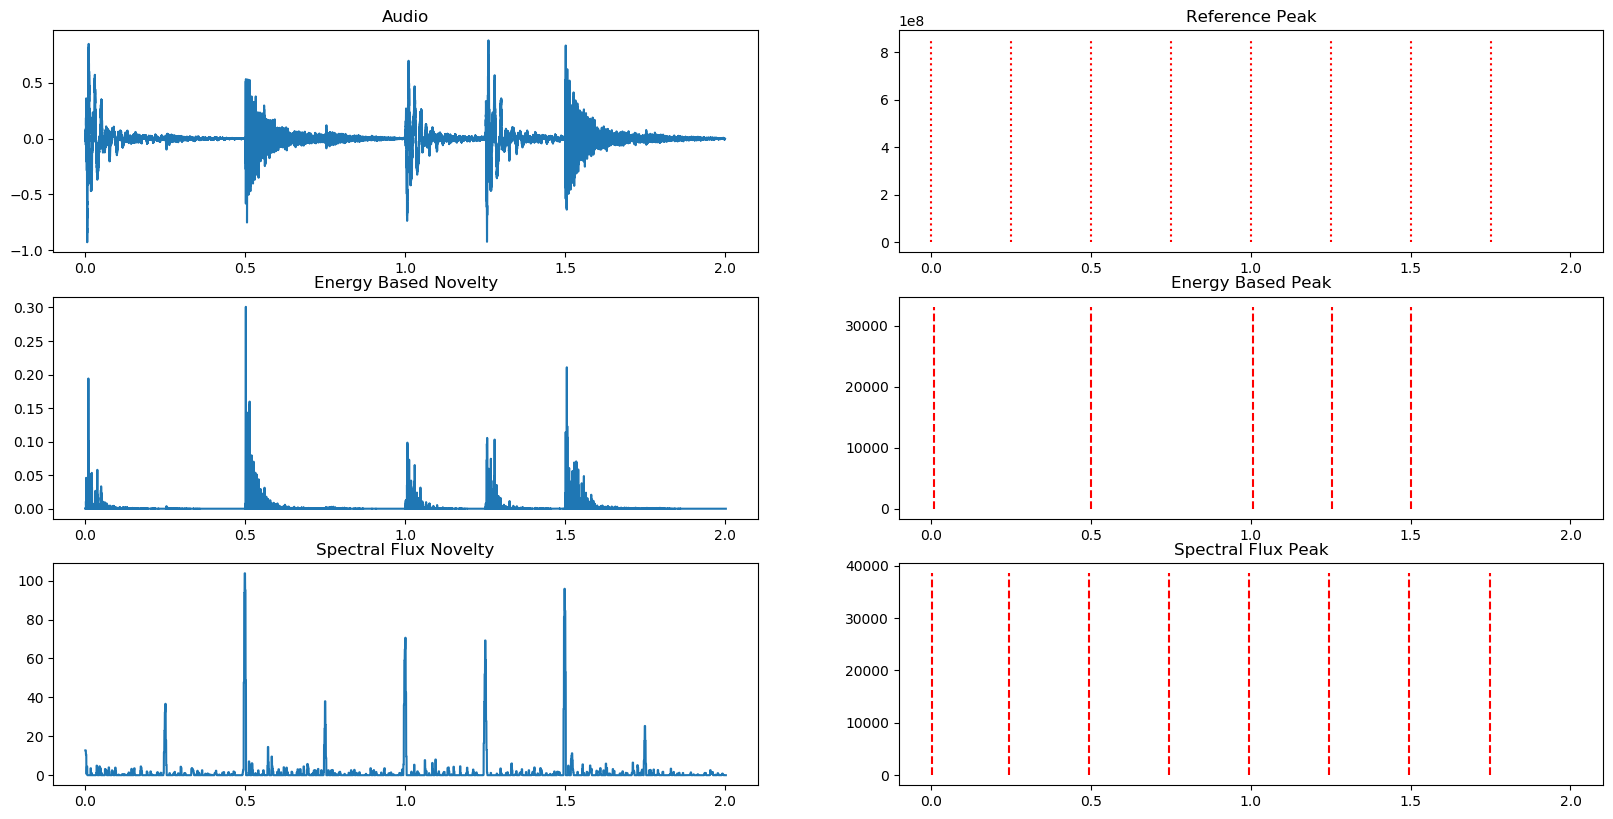

In [11]:
x, fs = librosa.load("audio/drums.aif")
ref_onsets = np.genfromtxt('audio/drums_reference.csv', delimiter=',')

tolerance = int(fs * 0.05)
length = len(x)

# Energy Based Novelty
energy_fn = calculate_novelty(x, win_size=128, n_f='energy', hop_size=False)
energy_detected_onsets = detect_onsets(energy_fn, mean_len=35, max_len=40, delta=0.05)
energy_evaluated_onsets = evaluate_onsets(ref_onsets, energy_detected_onsets, tolerance)
print(f'Energy f-measure: {energy_evaluated_onsets[2]}')

# Spectral Flux
spec_fn = calculate_novelty(x, win_size=128, n_f='spectral', hop_size=False)
spec_detected_onsets = detect_onsets(spec_fn, mean_len=50, max_len=50, delta=4)
spec_evaluated_onsets = evaluate_onsets(ref_onsets, spec_detected_onsets, tolerance)
print(f'Spectral Flux f-measure: {spec_evaluated_onsets[2]}')


f = plt.figure('Onset Detection Comparison', figsize=(20,10), dpi=100)
ax1 = plt.subplot(3, 2, 1)
plt.plot(x)
plt.title('Audio')

plt.subplot(3, 2, 3, sharex=ax1)
plt.plot(energy_fn)
plt.title('Energy Based Novelty')

plt.subplot(3, 2, 5, sharex=ax1)
plt.plot(spec_fn)
plt.title('Spectral Flux Novelty')

x_ticks = np.linspace(0, length, 5)
x_labels = np.linspace(0, length / fs, 5)
plt.xticks(x_ticks, x_labels, )


ax2 = plt.subplot(3, 2, 2, sharex=ax1)
plt.title('Reference Peak')
plt.vlines(ref_onsets / fs, 0, ref_onsets.max(), color='r', linestyle='dotted')

plt.subplot(3, 2, 4, sharex=ax1)
plt.title('Energy Based Peak')
plt.vlines(energy_detected_onsets, 0, energy_detected_onsets.max(), color='r', linestyle='dashed')

plt.subplot(3, 2, 6, sharex=ax1)
plt.title('Spectral Flux Peak')
plt.vlines(spec_detected_onsets, 0, spec_detected_onsets.max(), color='r', linestyle='dashed')

plt.xticks(x_ticks, x_labels)

#### ANALYSIS


Energy f-measure: 0.5555555555555556

Spectral Flux f-measure: 0.6666666666666666

For the first clip, the drum loop, both the energy based and spectral flux onset detection method seems to performed quite well when looking at the plot of the novelty function and the detected peaks. The window size of energy based detection really didn't matter that much and all of the results are pretty consistent dispite the change in window size. The delta on onset detection was quite important as choosing a different one than the current one, for example, picking a smaller number would add a lot of extra peaks that doesn't exist inside the original audio file. In the end, delta=0.05 gave me the best f measure score so I went with it. The mean_len and max_len didn't affect the f measure much unless a extremely small number was used.

The character of the sound clip is quite bass heavy. The high frequency is only realy present when there is a high hat. The bass drum and snare sounds like they have quite a bit of low frequency content, which is probably the reason why in the energy based novelty detection only the bass drum and snare have been counted as a peak. While on the other hand spectral flux picked up every single peak of the high hats as well as the bass drums and snares, which in this case makes it more accurate.

Energy f-measure: 0.29629629629629634
Spectral Flux f-measure: 0.0


([<matplotlib.axis.XTick at 0x1ffbdb6c508>,
 <a list of 5 Text xticklabel objects>)

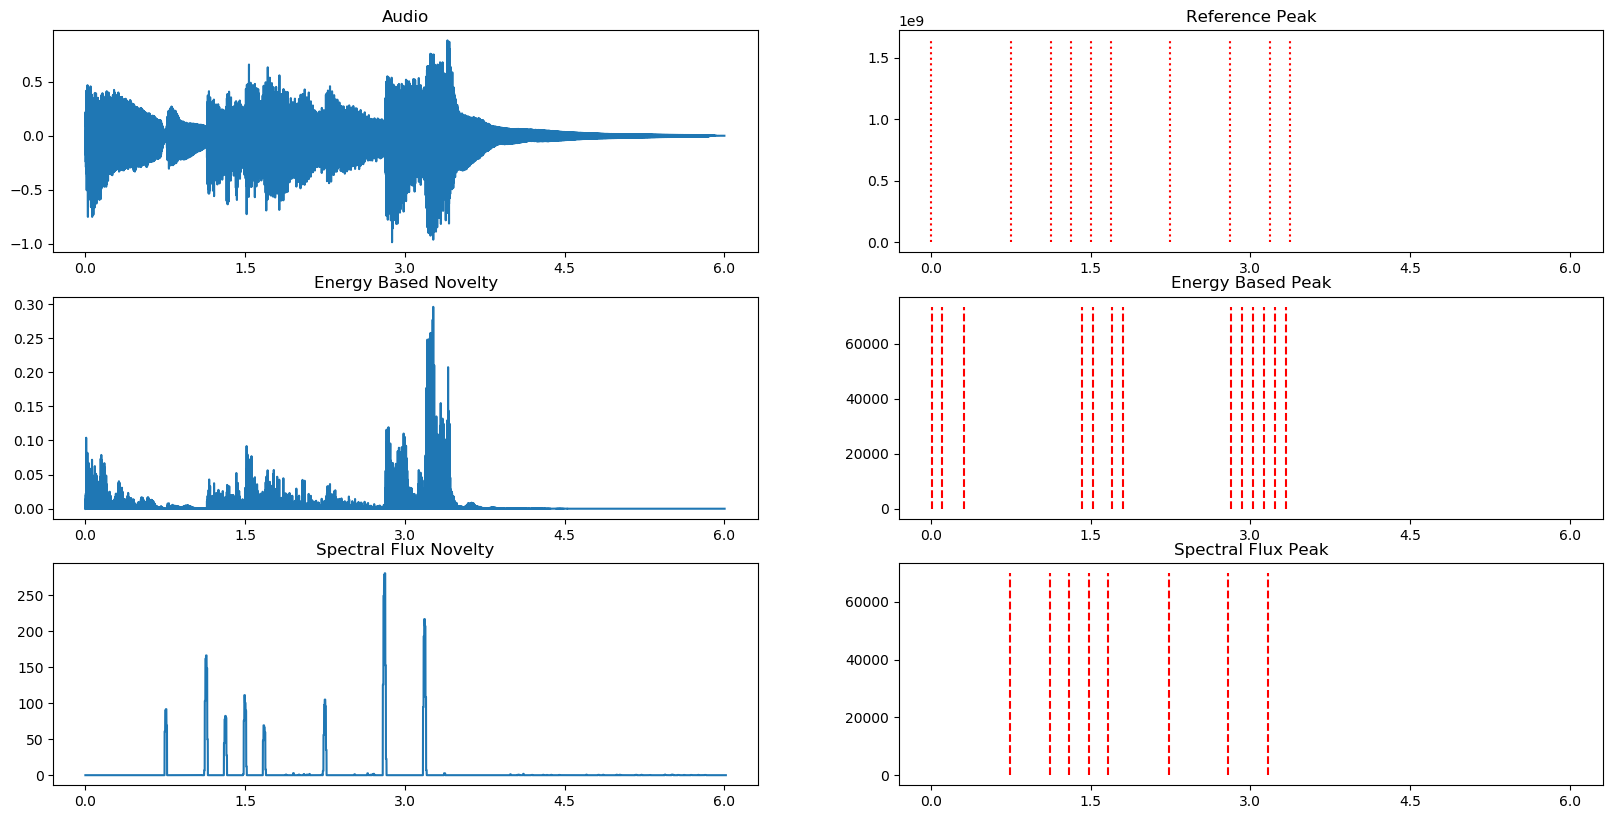

In [12]:
y, fs = librosa.load("audio/guitar.aif")
ref_onsets = np.genfromtxt('audio/guitar_reference.csv', delimiter=',')

tolerance = int(fs * 0.05)
length = len(y)

# Energy Based Novelty
energy_fn = calculate_novelty(y, win_size=64, n_f='energy', hop_size=False)
energy_detected_onsets = detect_onsets(energy_fn, mean_len=14, max_len=14, delta=0.03)
energy_evaluated_onsets = evaluate_onsets(ref_onsets, energy_detected_onsets, tolerance)
print(f'Energy f-measure: {energy_evaluated_onsets[2]}')

# Spectral Flux
spec_fn = calculate_novelty(y, win_size=512, n_f='spectral', hop_size=False)
spec_detected_onsets = detect_onsets(spec_fn, mean_len=50, max_len=50, delta=5)
spec_evaluated_onsets = evaluate_onsets(ref_onsets, spec_detected_onsets, tolerance)
print(f'Spectral Flux f-measure: {spec_evaluated_onsets[2]}')


f = plt.figure('Onset Detection Comparison', figsize=(20,10), dpi=100)
ax1 = plt.subplot(3, 2, 1)
plt.plot(y)
plt.title('Audio')

plt.subplot(3, 2, 3, sharex=ax1)
plt.plot(energy_fn)
plt.title('Energy Based Novelty')

plt.subplot(3, 2, 5, sharex=ax1)
plt.plot(spec_fn)
plt.title('Spectral Flux Novelty')

x_ticks = np.linspace(0, length, 5)
x_labels = np.linspace(0, length / fs, 5)
plt.xticks(x_ticks, x_labels, )


plt.subplot(3, 2, 2, sharex=ax1)
plt.title('Reference Peak')
plt.vlines(ref_onsets / fs, 0, ref_onsets.max(), color='r', linestyle='dotted')

plt.subplot(3, 2, 4, sharex=ax1)
plt.title('Energy Based Peak')
plt.vlines(energy_detected_onsets, 0, energy_detected_onsets.max(), color='r', linestyle='dashed')

plt.subplot(3, 2, 6, sharex=ax1)
plt.title('Spectral Flux Peak')
plt.vlines(spec_detected_onsets, 0, spec_detected_onsets.max(), color='r', linestyle='dashed')

plt.xticks(x_ticks, x_labels)

#### ANALYSIS

Energy f-measure: 0.29629629629629634

Spectral Flux f-measure: 0.6153846153846153

The parameters used are the most accurate result out of all the parameters that I have tested. Not much difference on the energy based novelty when I changed the input parameters. For the spectral flux one, I have found out that increasing the window size helps with the accuracy quite a bit, the plot of the spectral flux novelty function also seems clearer.

The guitar is played using a pick at different volume on each note. On top of that as the player plays harder, there were also a substantial amount of noise of the string vibrating against the fret board being introduced, which is in the higher frequency range. In this example, the energy based onset detection was not quite as good due to the nature of how the guitar was being played. As we can see, during the middle parts where the player were playing faster and quiter, it couldn't tell where the onset was. Spectral flux performed better as it is analysing the entire frequncy content to determine where the onset is and not just relying on how loud a note is being played.

Energy f-measure: 0.2
Spectral Flux f-measure: 0.0


C:\Users\Kang\anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: overflow encountered in long_scalars


([<matplotlib.axis.XTick at 0x1ffbfdcf988>,
 <a list of 5 Text xticklabel objects>)

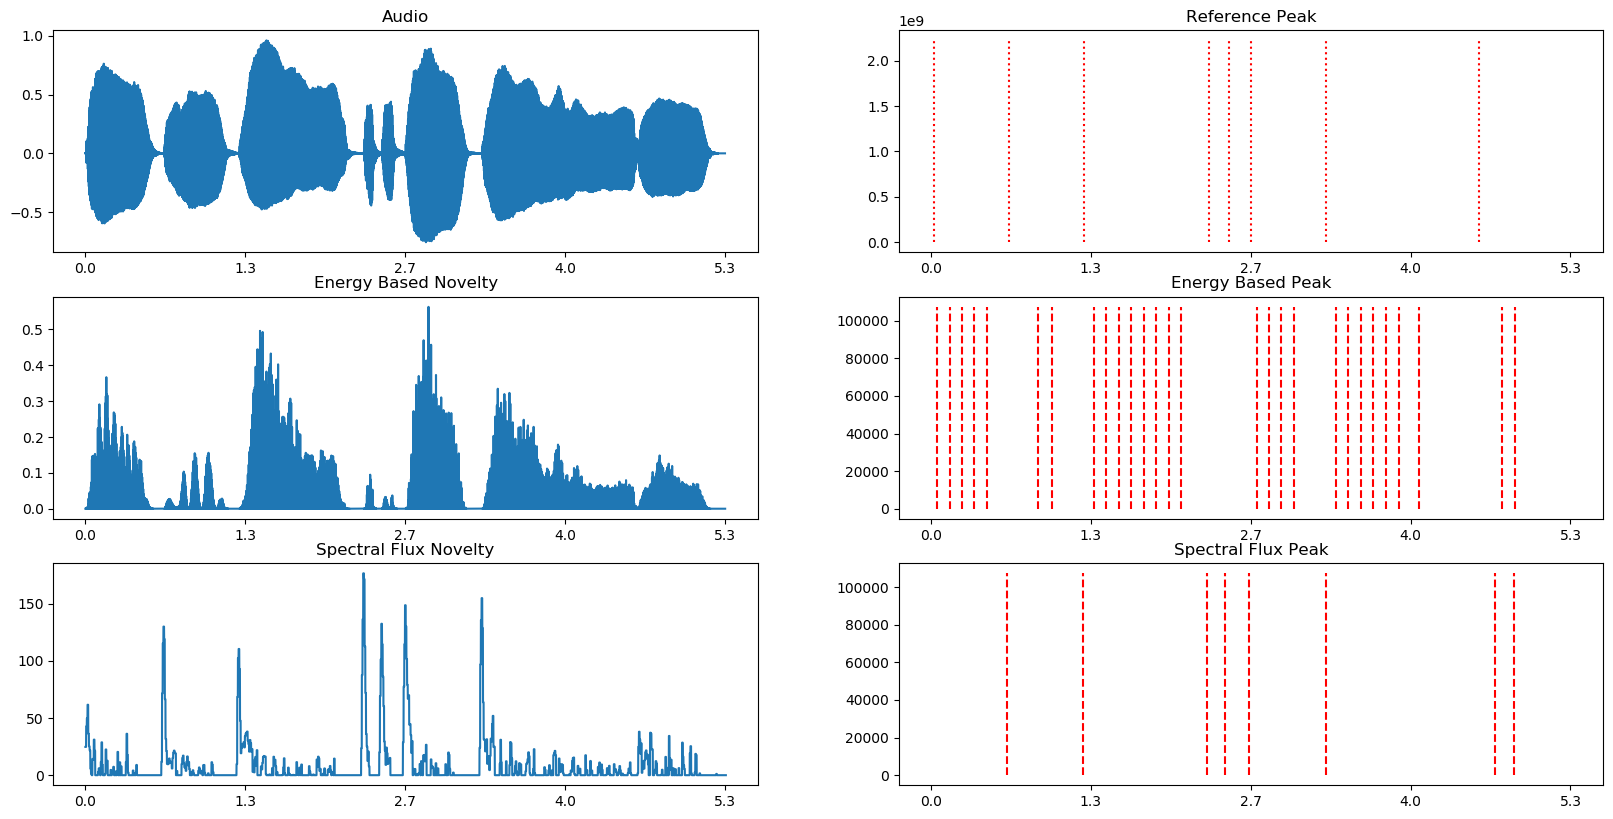

In [13]:
z, fs = librosa.load("audio/trumpet.aif")
reference_onsets = np.genfromtxt('audio/trumpet_reference.csv', delimiter=',')

tolerance = int(fs * 0.25)
length = len(z)

# Energy Based Novelty
energy_fn = calculate_novelty(z, win_size=32, n_f='energy', hop_size=False)
energy_detected_onsets = detect_onsets(energy_fn, mean_len=50, max_len=50, delta=0.1)
energy_evaluated_onsets = evaluate_onsets(reference_onsets, energy_detected_onsets, tolerance)
print(f'Energy f-measure: {energy_evaluated_onsets[2]}')

# Spectral Flux
spec_fn = calculate_novelty(z, win_size=512, n_f='spectral', hop_size=False)
spec_detected_onsets = detect_onsets(spec_fn, mean_len=100, max_len=100, delta=15)
spec_evaluated_onsets = evaluate_onsets(reference_onsets, spec_detected_onsets, tolerance)
print(f'Spectral Flux f-measure: {spec_evaluated_onsets[2]}')


f = plt.figure('Onset Detection Comparison', figsize=(20,10), dpi=100)
ax1 = plt.subplot(3, 2, 1)
plt.plot(z)
plt.title('Audio')

plt.subplot(3, 2, 3, sharex=ax1)
plt.plot(energy_fn)
plt.title('Energy Based Novelty')

plt.subplot(3, 2, 5, sharex=ax1)
plt.plot(spec_fn)
plt.title('Spectral Flux Novelty')

x_ticks = np.linspace(0, length, 5)
x_labels = np.round(np.linspace(0, length / fs, 5), 1)
plt.xticks(x_ticks, x_labels, )


plt.subplot(3, 2, 2, sharex=ax1)
plt.title('Reference Peak')
plt.vlines(reference_onsets / fs, 0, reference_onsets.max(), color='r', linestyle='dotted')

plt.subplot(3, 2, 4, sharex=ax1)
plt.title('Energy Based Peak')
plt.vlines(energy_detected_onsets, 0, energy_detected_onsets.max(), color='r', linestyle='dashed')

plt.subplot(3, 2, 6, sharex=ax1)
plt.title('Spectral Flux Peak')
plt.vlines(spec_detected_onsets, 0, spec_detected_onsets.max(), color='r', linestyle='dashed')

plt.xticks(x_ticks, x_labels)

#### ANALYSIS

Energy f-measure: 0.23809523809523808

Spectral Flux f-measure: 0.5454545454545454

The parameters used are the most accurate result out of all the parameters that I have tested. The mean_len and max_len of the detect_onsets function had to be increased for the energy based detection due to the trumpet not being able to play at a increadibly fast speed. The window size was lowered as well. I have also increased the tolerance window on the evaluation, since the trumpet is being played at a slower speed, which may or may not have cause inconsistency in the analysis.

The trumpet was being played at a pretty consistent volume. There is consistent buzz noise which is the characteristic of a brass instrument. The noise also increased as the trumpet is being played louder. In this example, the energy based detection really struggled to give good results and detected way more peak than there actually is. The constant buzzing of the instrument probably caused the energy to fluctuate quite a bit. Spectral flux performed better in this case. I think the reason behind this is that whenever the player plays a note there are a substantial amount of buzz noise that basically spreads across the entire frequency, which makes the onset more obvious.